In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import glob

In [26]:
image_size = (64, 64)

def load_image(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data[0, 0, 0]

    data = resize(data, (image_size[0], image_size[1]), anti_aliasing=True)
    data = (data - data.min()) / (data.max() - data.min())
    return data

In [27]:
def train_generator(file_list, batch_size):
    while True:
        np.random.shuffle(file_list)
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i + batch_size]
            batch_images = []
            for f in batch_files:
                try:
                    img = load_image(f)
                    
                    angle = np.random.randint(0, 4)                         # Random rotation: 0, 90, 180, or 270 degrees
                    img = np.rot90(img, k=angle)
                    batch_images.append(img)
                except Exception as e:
                    print(f"Error processing {f}: {str(e)}")
                    continue
            if batch_images:
                batch_images = np.array(batch_images)[..., np.newaxis]
                yield batch_images, batch_images

In [28]:
def val_generator(file_list, batch_size):
    while True:
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i + batch_size]
            batch_images = []
            for f in batch_files:
                try:
                    img = load_image(f)
                    batch_images.append(img)
                except Exception as e:
                    print(f"Error processing {f}: {str(e)}")
                    continue
            if batch_images:
                batch_images = np.array(batch_images)[..., np.newaxis]
                yield batch_images, batch_images

In [29]:
def build_autoencoder(latent_dim):
    input_img = Input(shape=(image_size[0], image_size[1], 1))
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    encoded = Dense(latent_dim, name='latent')(x)
    
    x = Dense(64, activation='relu')(encoded)
    x = Dense(64 * 8 * 8, activation='relu')(x)
    x = Reshape((8, 8, 64))(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(1, (3, 3), strides=2, activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, x)
    encoder = Model(input_img, encoded)
    
    return autoencoder, encoder

In [53]:
def main():
    seed_value = 42
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    batch_size = 32
    latent_dim = 35
    epochs = 50

    data_dir = '../continuum_data_subset'

    file_list = glob.glob(os.path.join(data_dir, '*.fits'))
    if not file_list:
        raise ValueError(f"No .fits files found in {data_dir}. Please check the directory path.")

    train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=seed_value)
    print(f"Training files: {len(train_files)}, Validation files: {len(val_files)}")
    
    autoencoder, encoder = build_autoencoder(latent_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        train_generator(train_files, batch_size),
        steps_per_epoch=max(len(train_files) // batch_size, 1),
        validation_data=val_generator(val_files, batch_size),
        validation_steps=max(len(val_files) // batch_size, 1),
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    autoencoder.save('autoencoder.keras')
    print("Model saved.")

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show('training_history.png')
    plt.close()

    latent_reps = []
    for i in range(0, len(file_list), batch_size):
        batch_files = file_list[i:i + batch_size]
        batch_images = []
        for f in batch_files:
            try:
                img = load_image(f)
                batch_images.append(img)
            except Exception as e:
                print(f"Error processing {f}: {str(e)}")
                continue
        if batch_images:
            batch_images = np.array(batch_images)[..., np.newaxis]
            batch_latent = encoder.predict(batch_images, verbose=0)
            latent_reps.append(batch_latent)
    latent_reps = np.concatenate(latent_reps, axis=0)
    print(f"Latent representations shape: {latent_reps.shape}")

    k_range = range(2, min(10, len(file_list) - 1))
    silhouette_scores = []
    wcss = []

    # silhouette scores for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=seed_value, n_init=10)
        labels = kmeans.fit_predict(latent_reps)
        score = silhouette_score(latent_reps, labels)
        silhouette_scores.append(score)
        print(f"k={k}, Silhouette Score={score:.4f}")

    # ecss for elbow method
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=seed_value, n_init=10)
        kmeans.fit(latent_reps)
        wcss.append(kmeans.inertia_)

    # silhouette scores vs wcss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Silhouette Score', color='tab:blue')
    ax1.plot(list(k_range), silhouette_scores, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('WCSS', color='tab:red')
    ax2.plot(list(k_range), wcss, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Silhouette Score and WCSS vs. Number of Clusters')
    fig.tight_layout()
    plt.show('cluster_metrics.png')
    plt.close()

    best_k = list(k_range)[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {best_k}")
    print("Inspect 'cluster_metrics.png' to consider the elbow point for WCSS")

    kmeans = KMeans(n_clusters=best_k, random_state=seed_value, n_init='auto')
    labels = kmeans.fit_predict(latent_reps)

    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=seed_value)
    latent_2d = tsne.fit_transform(latent_reps)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', s=50)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show('tsne_visualization.png')
    plt.close()

    for cluster in range(best_k):
        cluster_indices = np.where(labels == cluster)[0]
        num_samples = min(5, len(cluster_indices))
        if num_samples == 0:
            print(f"Cluster {cluster} is empty.")
            continue

        selected_indices = sorted(cluster_indices)[:num_samples]
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        fig.suptitle(f'Cluster {cluster} (Size: {len(cluster_indices)})')
        for ax, idx in zip(axes if num_samples > 1 else [axes], selected_indices):
            try:
                img = load_image(file_list[idx])
                ax.imshow(img, cmap='gray')
                ax.axis('off')
                ax.set_title(f'{os.path.basename(file_list[idx])}')
            except Exception as e:
                print(f"Error processing {file_list[idx]}: {str(e)}")
                continue
        plt.show(f'cluster_{cluster}_representatives.png')
        plt.close()

    df = pd.DataFrame({'file_name': file_list, 'cluster_label': labels})
    df.to_csv('cluster_labels.csv', index=False)
    print("Cluster labels saved to 'cluster_labels.csv'.")

Training files: 120, Validation files: 30


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,517 (2.45 MB)

 Trainable params: 642,517 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 744ms/step - loss: 0.1879 - val_loss: 0.1822
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.1798 - val_loss: 0.1807
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.1871 - val_loss: 0.1787
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.1818 - val_loss: 0.1749
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.1756 - val_loss: 0.1619
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.1521 - val_loss: 0.1110
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0943 - val_loss: 0.0540
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0517 - val_loss: 0.0471
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0457 - val_loss: 0.0452
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0447 - val_loss: 0.0418
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0368 - val_loss: 0.0394
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0395 - val_lo

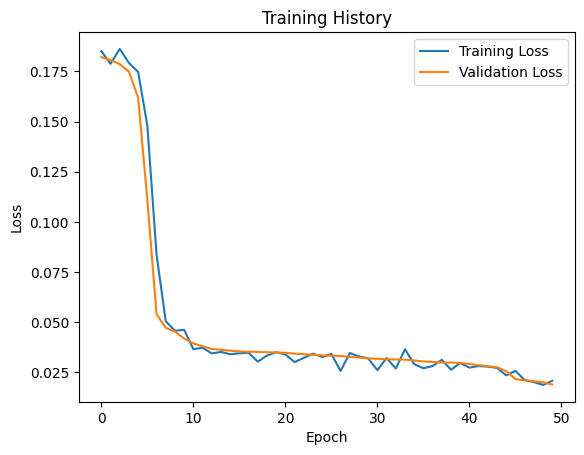

2025-03-23 02:34:24.074466: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-23 02:34:24.075068: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Latent representations shape: (150, 20)
k=2, Silhouette Score=0.6253
k=3, Silhouette Score=0.5844
k=4, Silhouette Score=0.5853
k=5, Silhouette Score=0.5807
k=6, Silhouette Score=0.5620
k=7, Silhouette Score=0.5344
k=8, Silhouette Score=0.5250
k=9, Silhouette Score=0.5017


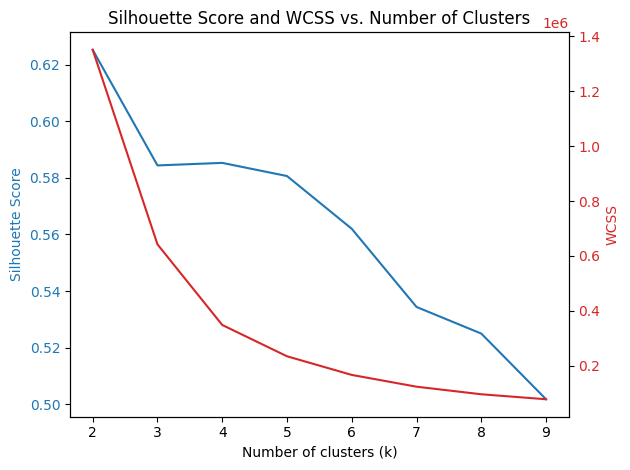

Optimal number of clusters based on silhouette score: 2
Inspect 'cluster_metrics.png' to consider the elbow point for WCSS


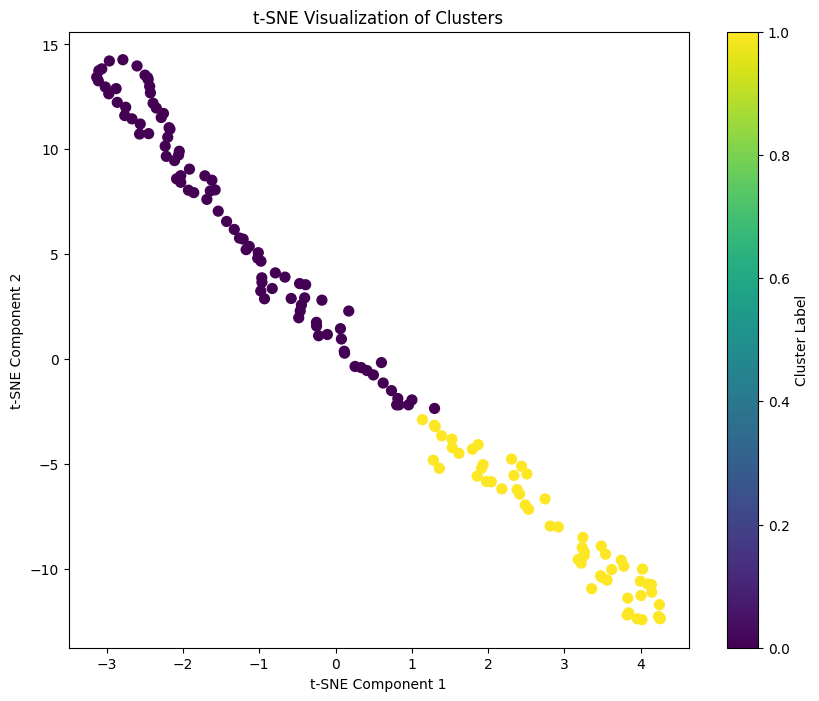

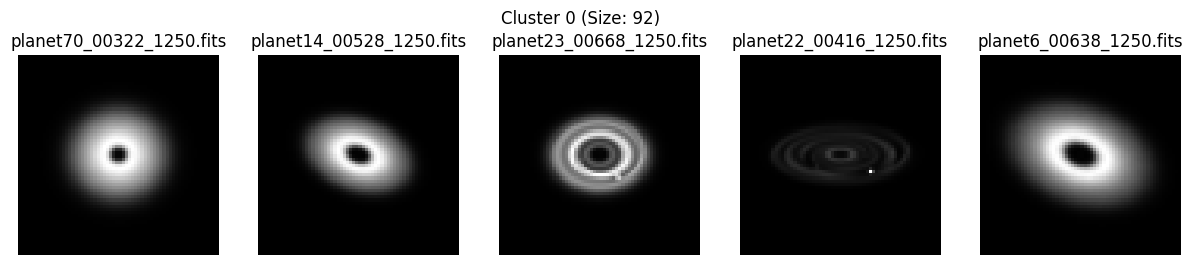

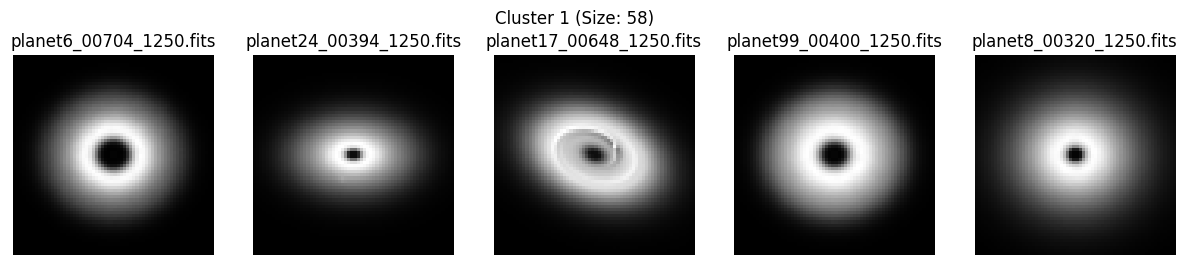

Cluster labels saved to 'cluster_labels.csv'.


In [41]:
if __name__ == '__main__':
    main()

Training files: 120, Validation files: 30


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 35)             │         2,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_63             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_64             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_65             │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,452 (2.46 MB)

 Trainable params: 644,452 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1879 - val_loss: 0.1822
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1798 - val_loss: 0.1808
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 841ms/step - loss: 0.1872 - val_loss: 0.1788
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 881ms/step - loss: 0.1818 - val_loss: 0.1740
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 827ms/step - loss: 0.1734 - val_loss: 0.1515
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.1360 - val_loss: 0.0847
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 830ms/step - loss: 0.0740 - val_loss: 0.0540
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step - loss: 0.0539 - val_loss: 0.0526
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step - loss: 0.0520 - val_loss: 0.0502
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.0508 - val_loss: 0.0483
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - loss: 0.0446 - val_loss: 0.0468
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 788ms/step - loss: 0.0472 - val_loss: 0.0443
E

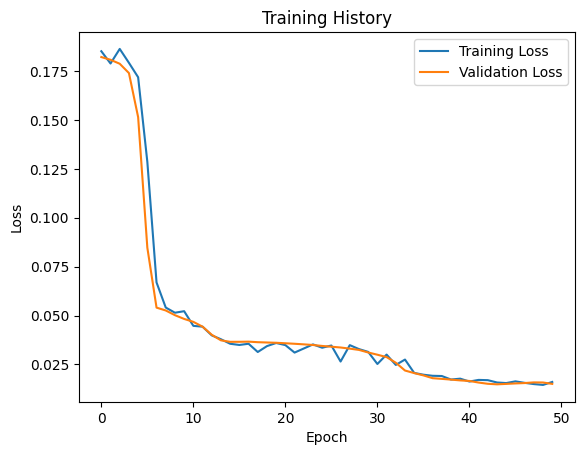

2025-03-29 22:02:37.587815: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-29 22:02:37.588804: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Latent representations shape: (150, 35)
k=2, Silhouette Score=0.6040
k=3, Silhouette Score=0.5458
k=4, Silhouette Score=0.5451
k=5, Silhouette Score=0.5426
k=6, Silhouette Score=0.5676
k=7, Silhouette Score=0.5501
k=8, Silhouette Score=0.5496
k=9, Silhouette Score=0.5258


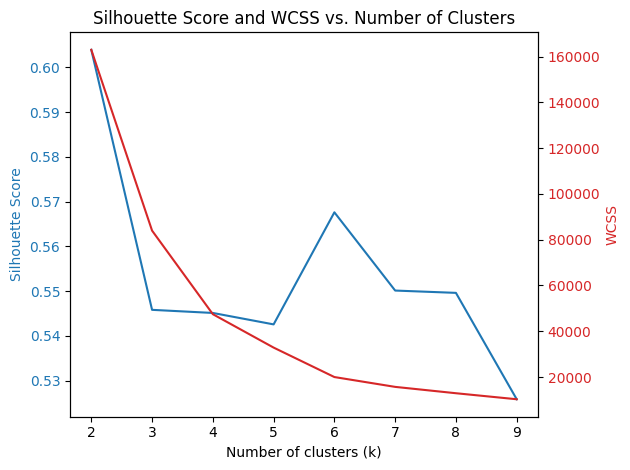

Optimal number of clusters based on silhouette score: 2
Inspect 'cluster_metrics.png' to consider the elbow point for WCSS


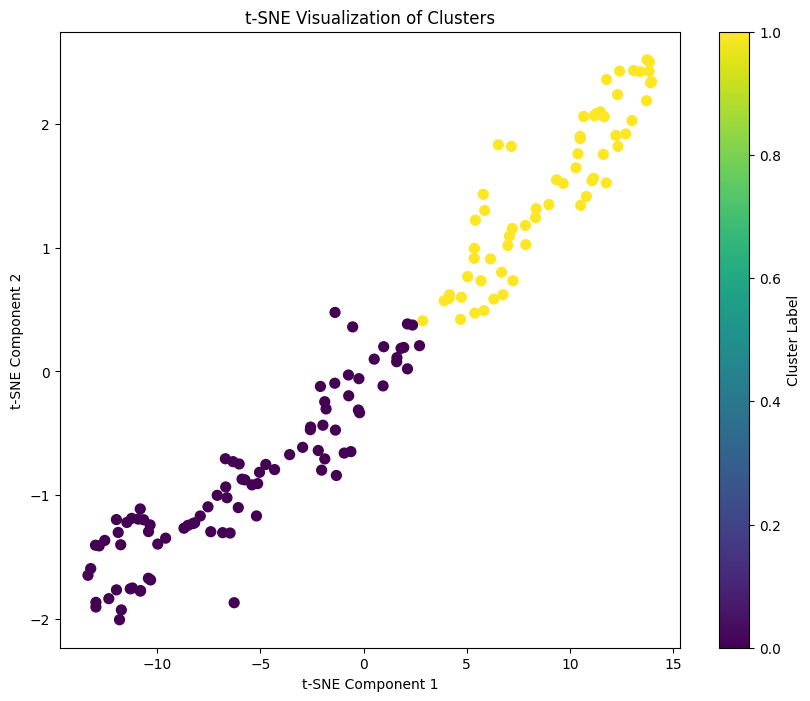

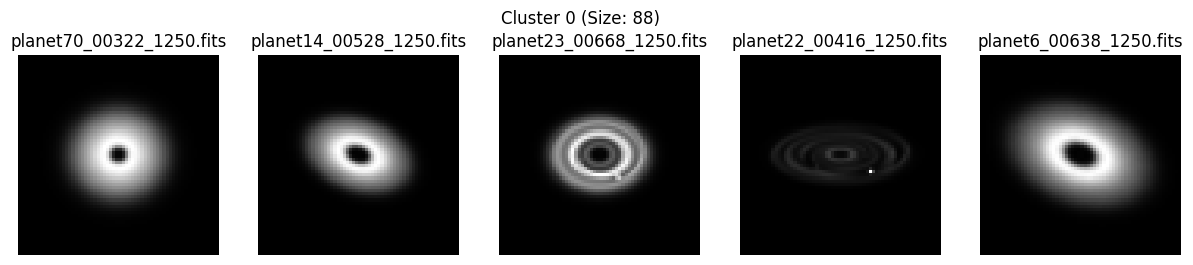

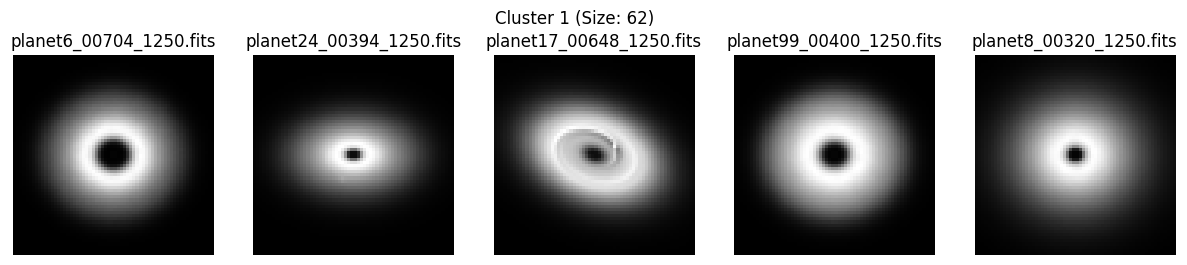

Cluster labels saved to 'cluster_labels.csv'.


In [54]:
if __name__ == '__main__':
    main()

Training files: 120, Validation files: 30


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_20 (Reshape)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_60             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_61             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_62             │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,807 (2.46 MB)

 Trainable params: 643,807 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1879 - val_loss: 0.1822
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.1798 - val_loss: 0.1808
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - loss: 0.1872 - val_loss: 0.1786
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - loss: 0.1814 - val_loss: 0.1720
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - loss: 0.1697 - val_loss: 0.1397
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - loss: 0.1213 - val_loss: 0.0713
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step - loss: 0.0644 - val_loss: 0.0531
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - loss: 0.0532 - val_loss: 0.0517
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - loss: 0.0509 - val_loss: 0.0492
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - loss: 0.0498 - val_loss: 0.0480
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - loss: 0.0443 - val_loss: 0.0469
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - loss: 0.0474 - val_loss:

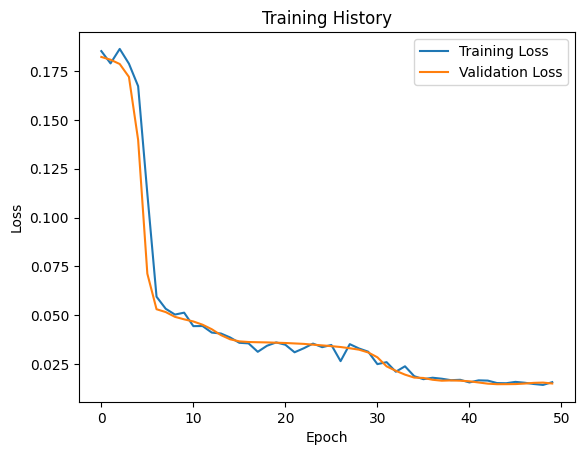

2025-03-29 21:57:59.056949: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-29 21:57:59.059232: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Latent representations shape: (150, 30)
k=2, Silhouette Score=0.5875
k=3, Silhouette Score=0.5702
k=4, Silhouette Score=0.5262
k=5, Silhouette Score=0.5382
k=6, Silhouette Score=0.5331
k=7, Silhouette Score=0.5087
k=8, Silhouette Score=0.5243
k=9, Silhouette Score=0.5266


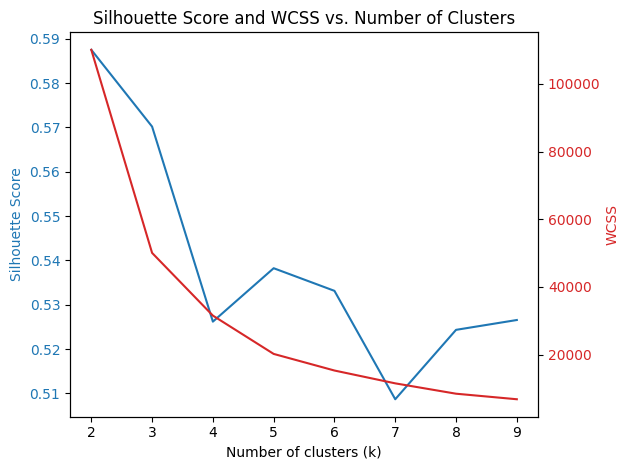

Optimal number of clusters based on silhouette score: 2
Inspect 'cluster_metrics.png' to consider the elbow point for WCSS


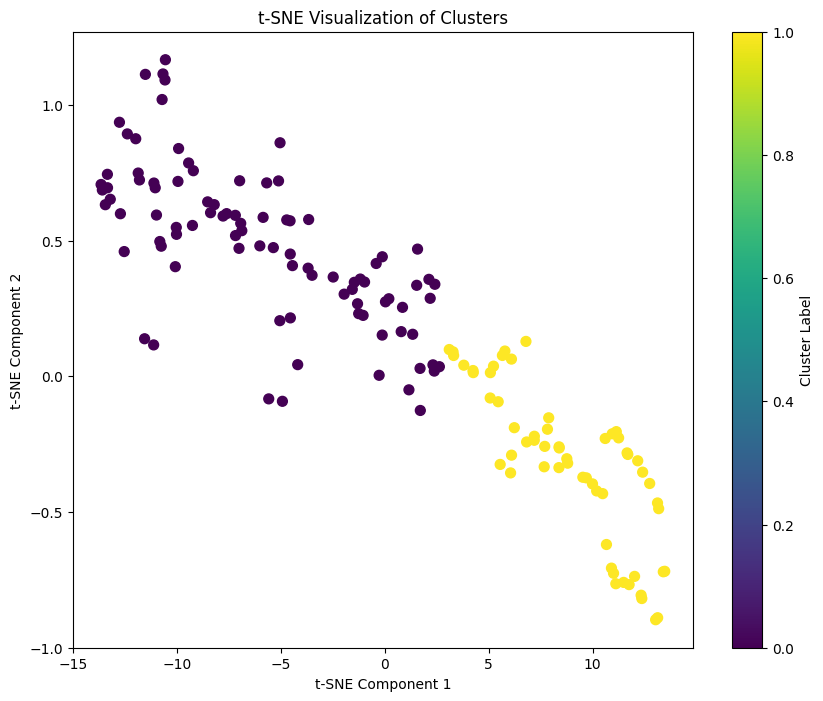

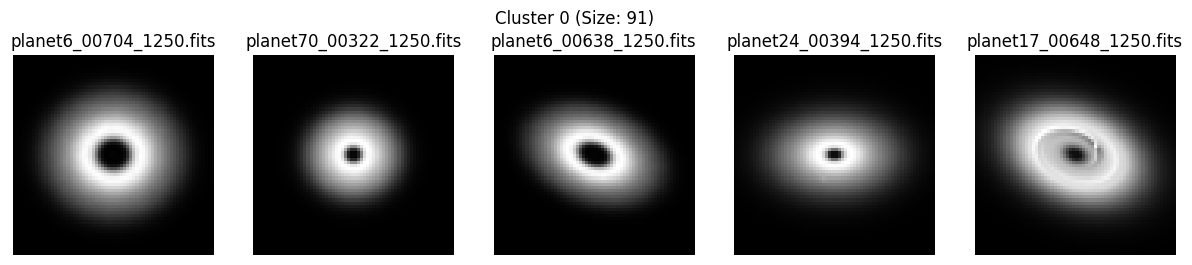

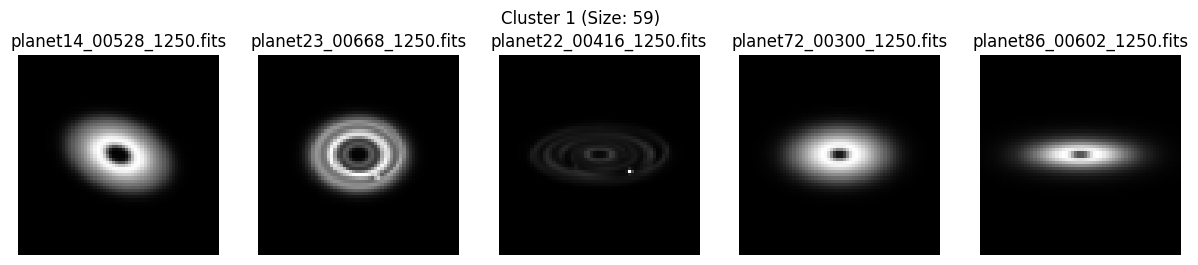

Cluster labels saved to 'cluster_labels.csv'.


In [52]:
if __name__ == '__main__':
    main()